# Cross-Exchange BTC/USD Wedge Analysis: Binance.US vs Coinbase vs Kraken
**IAQF 2026 Student Competition — Option 1: Kraken Cross-Exchange Analysis**

*Author: Columbia MAFN*

This notebook addresses **Research Question 2** ("premium/discount patterns vary across exchanges and regimes")
by constructing three pairwise BTC/USD venue wedges using 1-minute OHLC data from Binance.US, Coinbase,
and Kraken for March 1–21, 2023. We also compare stablecoin FX deviations (USDC/USD, USDT/USD, USDC/USDT)
across Binance.US and Kraken to show whether the March 2023 USDC de-peg was a venue-specific or market-wide event.

**Data sources:**
- Binance.US: 1-min klines via REST API (`api.binance.us`)
- Coinbase: 1-min candles via REST API (`api.exchange.coinbase.com`)
- Kraken: tick trades paginated via REST API (`api.kraken.com/0/public/Trades`) → resampled to 1-min OHLC

**Regime definitions:**
| Regime | Dates | Economic context |
|--------|-------|-----------------|
| Pre-crisis | Mar 1–9 | USDC/USD ≈ 1.000, normal microstructure |
| Crisis | Mar 10–12 | SVB collapse, USDC/USD fell to 0.863 |
| Recovery | Mar 13–15 | USDC/USD recovering toward par |
| Post | Mar 16–21 | USDC/USD ≈ 0.997, new normal |


## §1 Setup and Data Loading

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests, time, datetime

# ── Paths (all relative to notebook location) ──────────────────────────────
NB_DIR  = Path().resolve()
DATA_DIR = NB_DIR.parent / "data" / "cross_exchange"
FIG_DIR  = NB_DIR.parent / "figures" / "kraken"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ── Style ──────────────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.dpi': 150, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.grid': True, 'grid.alpha': 0.3, 'font.size': 10,
    'axes.titlesize': 12, 'axes.labelsize': 10, 'legend.fontsize': 9,
})
COLORS = {'binance': '#F0B90B', 'coinbase': '#0052FF', 'kraken': '#5741D9',
          'pre': '#2196F3', 'crisis': '#F44336', 'recovery': '#FF9800', 'post': '#4CAF50'}

# ── Regime definitions ─────────────────────────────────────────────────────
REGIMES = {
    'pre_crisis': (pd.Timestamp('2023-03-01', tz='UTC'), pd.Timestamp('2023-03-10', tz='UTC')),
    'crisis':     (pd.Timestamp('2023-03-10', tz='UTC'), pd.Timestamp('2023-03-13', tz='UTC')),
    'recovery':   (pd.Timestamp('2023-03-13', tz='UTC'), pd.Timestamp('2023-03-16', tz='UTC')),
    'post':       (pd.Timestamp('2023-03-16', tz='UTC'), pd.Timestamp('2023-03-22', tz='UTC')),
}
REGIME_COLORS = {'pre_crisis': '#E3F2FD', 'crisis': '#FFEBEE', 'recovery': '#FFF3E0', 'post': '#E8F5E9'}

def add_regime_shading(ax, alpha=0.25):
    for name, (s, e) in REGIMES.items():
        ax.axvspan(s, e, alpha=alpha, color=REGIME_COLORS[name], zorder=0)

def label_regime(ax, y_frac=0.97):
    labels = {'pre_crisis': 'Pre-Crisis', 'crisis': 'Crisis', 'recovery': 'Recovery', 'post': 'Post'}
    lcolors = {'pre_crisis': '#1565C0', 'crisis': '#C62828', 'recovery': '#E65100', 'post': '#2E7D32'}
    for name, (s, e) in REGIMES.items():
        mid = s + (e - s) / 2
        ax.text(mid, ax.get_ylim()[0] + y_frac*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                labels[name], ha='center', va='top', fontsize=8,
                color=lcolors[name], fontweight='bold')

def assign_regime(ts):
    for name, (s, e) in REGIMES.items():
        if s <= ts < e:
            return name
    return 'other'

print("Setup complete.")


Setup complete.


## §2 Load and Align Data from All Three Venues

In [2]:

# ── Load Kraken data ────────────────────────────────────────────────────────
def load_parquet_safe(path):
    if not path.exists():
        print(f"  WARNING: {path.name} not found")
        return pd.DataFrame()
    df = pd.read_parquet(path)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True)
    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    return df

kraken_btcusd  = load_parquet_safe(DATA_DIR / "kraken_btcusd_1min.parquet")
kraken_usdcusd = load_parquet_safe(DATA_DIR / "kraken_usdcusd_1min.parquet")
kraken_usdtusd = load_parquet_safe(DATA_DIR / "kraken_usdtusd_1min.parquet")
kraken_usdcusdt= load_parquet_safe(DATA_DIR / "kraken_usdcusdt_1min.parquet")

print(f"Kraken BTC/USD:   {len(kraken_btcusd):,} rows  ({kraken_btcusd.index.min()} to {kraken_btcusd.index.max()})" if not kraken_btcusd.empty else "Kraken BTC/USD: MISSING")
print(f"Kraken USDC/USD:  {len(kraken_usdcusd):,} rows" if not kraken_usdcusd.empty else "Kraken USDC/USD: MISSING")
print(f"Kraken USDT/USD:  {len(kraken_usdtusd):,} rows" if not kraken_usdtusd.empty else "Kraken USDT/USD: MISSING")
print(f"Kraken USDC/USDT: {len(kraken_usdcusdt):,} rows" if not kraken_usdcusdt.empty else "Kraken USDC/USDT: MISSING")

# ── Fetch Binance.US BTC/USD 1-min (re-fetch inline if parquet missing) ─────
def fetch_binanceus_klines(symbol, start_ms, end_ms, interval="1m"):
    BASE = "https://api.binance.us/api/v3/klines"
    all_rows = []
    cur = start_ms
    while cur < end_ms:
        r = requests.get(BASE, params={"symbol": symbol, "interval": interval,
                                        "startTime": cur, "endTime": end_ms,
                                        "limit": 1000}, timeout=15)
        rows = r.json()
        if not rows or isinstance(rows, dict):
            break
        all_rows.extend(rows)
        cur = rows[-1][0] + 60000
        time.sleep(0.1)
    if not all_rows:
        return pd.DataFrame()
    df = pd.DataFrame(all_rows, columns=[
        'open_time','open','high','low','close','volume',
        'close_time','quote_vol','n_trades','taker_buy_vol','taker_buy_quote','ignore'])
    df['timestamp_utc'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df = df.set_index('timestamp_utc')
    for c in ['open','high','low','close','volume']:
        df[c] = df[c].astype(float)
    return df[['open','high','low','close','volume','n_trades']]

START_MS = int(datetime.datetime(2023, 3, 1).timestamp() * 1000)
END_MS   = int(datetime.datetime(2023, 3, 22).timestamp() * 1000)

print("\nFetching Binance.US BTC/USD...")
bnus_btcusd = fetch_binanceus_klines("BTCUSD", START_MS, END_MS)
print(f"Binance.US BTC/USD: {len(bnus_btcusd):,} rows")

print("Fetching Binance.US USDC/USD...")
bnus_usdcusd = fetch_binanceus_klines("USDCUSD", START_MS, END_MS)
print(f"Binance.US USDC/USD: {len(bnus_usdcusd):,} rows")

print("Fetching Binance.US USDT/USD...")
bnus_usdtusd = fetch_binanceus_klines("USDTUSD", START_MS, END_MS)
print(f"Binance.US USDT/USD: {len(bnus_usdtusd):,} rows")

# ── Fetch Coinbase BTC-USD ──────────────────────────────────────────────────
def fetch_coinbase_candles(product, start_dt, end_dt, granularity=60):
    BASE = "https://api.exchange.coinbase.com/products"
    all_rows = []
    cur = start_dt
    step = datetime.timedelta(seconds=granularity * 300)
    while cur < end_dt:
        nxt = min(cur + step, end_dt)
        try:
            r = requests.get(f"{BASE}/{product}/candles",
                             params={"granularity": granularity,
                                     "start": cur.isoformat(),
                                     "end": nxt.isoformat()}, timeout=15)
            rows = r.json()
            if isinstance(rows, list):
                all_rows.extend(rows)
        except Exception:
            pass
        cur = nxt
        time.sleep(0.3)
    if not all_rows:
        return pd.DataFrame()
    df = pd.DataFrame(all_rows, columns=['time','low','high','open','close','volume'])
    df['timestamp_utc'] = pd.to_datetime(df['time'], unit='s', utc=True)
    df = df.set_index('timestamp_utc').sort_index()
    for c in ['open','high','low','close','volume']:
        df[c] = df[c].astype(float)
    return df[['open','high','low','close','volume']]

print("\nFetching Coinbase BTC-USD...")
start_dt = datetime.datetime(2023, 3, 1, tzinfo=datetime.timezone.utc)
end_dt   = datetime.datetime(2023, 3, 22, tzinfo=datetime.timezone.utc)
cb_btcusd = fetch_coinbase_candles("BTC-USD", start_dt, end_dt)
print(f"Coinbase BTC-USD: {len(cb_btcusd):,} rows")


Kraken BTC/USD:   29,881 rows  (2023-03-01 05:00:00+00:00 to 2023-03-21 23:59:00+00:00)
Kraken USDC/USD:  20,794 rows
Kraken USDT/USD: MISSING
Kraken USDC/USDT: MISSING

Fetching Binance.US BTC/USD...


Binance.US BTC/USD: 30,181 rows
Fetching Binance.US USDC/USD...


Binance.US USDC/USD: 30,181 rows
Fetching Binance.US USDT/USD...


Binance.US USDT/USD: 30,181 rows

Fetching Coinbase BTC-USD...


Coinbase BTC-USD: 30,050 rows


## §3 Construct 3-Way BTC/USD Venue Wedges

In [3]:

# Deduplicate all series before alignment (Coinbase API can return duplicate timestamps)
def dedup(df):
    return df[~df.index.duplicated(keep='last')].sort_index()

bnus_btcusd   = dedup(bnus_btcusd)
cb_btcusd     = dedup(cb_btcusd)
if not kraken_btcusd.empty:
    kraken_btcusd = dedup(kraken_btcusd)

# Align all three BTC/USD series on a common 1-min UTC index
idx = bnus_btcusd.index.union(cb_btcusd.index)
if not kraken_btcusd.empty:
    idx = idx.union(kraken_btcusd.index)
idx = idx[~idx.duplicated()].sort_values()

# Use close prices; forward-fill gaps up to 5 minutes
p_bnus   = bnus_btcusd['close'].reindex(idx).ffill(limit=5)
p_cb     = cb_btcusd['close'].reindex(idx).ffill(limit=5)
p_kraken = kraken_btcusd['close'].reindex(idx).ffill(limit=5) if not kraken_btcusd.empty else pd.Series(np.nan, index=idx)

# Log venue wedges (in bps)
wedge_BC = (np.log(p_bnus) - np.log(p_cb))     * 10000   # Binance.US vs Coinbase
wedge_BK = (np.log(p_bnus) - np.log(p_kraken)) * 10000   # Binance.US vs Kraken
wedge_CK = (np.log(p_cb)   - np.log(p_kraken)) * 10000   # Coinbase vs Kraken

# Build panel
panel = pd.DataFrame({
    'p_bnus':   p_bnus,
    'p_cb':     p_cb,
    'p_kraken': p_kraken,
    'wedge_BC': wedge_BC,
    'wedge_BK': wedge_BK,
    'wedge_CK': wedge_CK,
}, index=idx)
panel = panel.dropna(subset=['p_bnus', 'p_cb'])
panel['regime'] = panel.index.map(assign_regime)
panel = panel[panel['regime'] != 'other']

print(f"Panel rows: {len(panel):,}")
print(f"\nWedge summary (bps):")
print(panel[['wedge_BC','wedge_BK','wedge_CK']].describe().round(2))


Panel rows: 29,668

Wedge summary (bps):
       wedge_BC  wedge_BK  wedge_CK
count  29668.00  29661.00  29661.00
mean      -3.39     -1.17      2.21
std        6.83      7.72      6.22
min      -82.95    -63.80    -29.51
25%       -4.26     -3.54     -1.01
50%       -0.95     -0.61      0.71
75%        0.27      1.79      3.78
max       21.70     35.19     57.45


## §4 Stablecoin FX Deviation: Binance.US vs Kraken

In [4]:

# Align stablecoin FX series
if not kraken_usdcusd.empty and not bnus_usdcusd.empty:
    # Deduplicate stablecoin series before alignment
    bnus_usdcusd   = dedup(bnus_usdcusd)
    kraken_usdcusd = dedup(kraken_usdcusd)
    if not bnus_usdtusd.empty:   bnus_usdtusd   = dedup(bnus_usdtusd)
    if not kraken_usdtusd.empty: kraken_usdtusd = dedup(kraken_usdtusd)

    fx_idx = bnus_usdcusd.index.union(kraken_usdcusd.index)
    fx_idx = fx_idx[~fx_idx.duplicated()].sort_values()
    usdc_bnus   = bnus_usdcusd['close'].reindex(fx_idx).ffill(limit=5)
    usdc_kraken = kraken_usdcusd['close'].reindex(fx_idx).ffill(limit=5)
    usdt_bnus   = bnus_usdtusd['close'].reindex(fx_idx).ffill(limit=5) if not bnus_usdtusd.empty else pd.Series(np.nan, index=fx_idx)
    usdt_kraken = kraken_usdtusd['close'].reindex(fx_idx).ffill(limit=5) if not kraken_usdtusd.empty else pd.Series(np.nan, index=fx_idx)

    fx_panel = pd.DataFrame({
        'usdc_bnus':   usdc_bnus,
        'usdc_kraken': usdc_kraken,
        'usdt_bnus':   usdt_bnus,
        'usdt_kraken': usdt_kraken,
        'usdc_dev_bnus':   (usdc_bnus   - 1) * 10000,
        'usdc_dev_kraken': (usdc_kraken - 1) * 10000,
        'usdt_dev_bnus':   (usdt_bnus   - 1) * 10000,
        'usdt_dev_kraken': (usdt_kraken - 1) * 10000,
    }, index=fx_idx)
    fx_panel['regime'] = fx_panel.index.map(assign_regime)
    fx_panel = fx_panel[fx_panel['regime'] != 'other']
    print(f"FX panel rows: {len(fx_panel):,}")
    print("\nUSDC/USD deviation by venue (bps):")
    print(fx_panel.groupby('regime')[['usdc_dev_bnus','usdc_dev_kraken']].agg(['mean','std','min']).round(2))
else:
    fx_panel = pd.DataFrame()
    print("Stablecoin FX data not available for cross-venue comparison")


FX panel rows: 29,940

USDC/USD deviation by venue (bps):
           usdc_dev_bnus                 usdc_dev_kraken                
                    mean     std     min            mean     std     min
regime                                                                  
crisis           -299.51  308.20 -1367.0         -306.60  304.75 -1260.0
post               -4.60    5.77   -35.0           -5.33    7.36   -32.0
pre_crisis         -0.76    4.38   -50.0           -0.45    0.52   -10.0
recovery          -35.06   37.53  -498.0          -21.24   28.74  -121.0


## §5 Figure K-1: 3-Way BTC/USD Venue Wedge Time Series

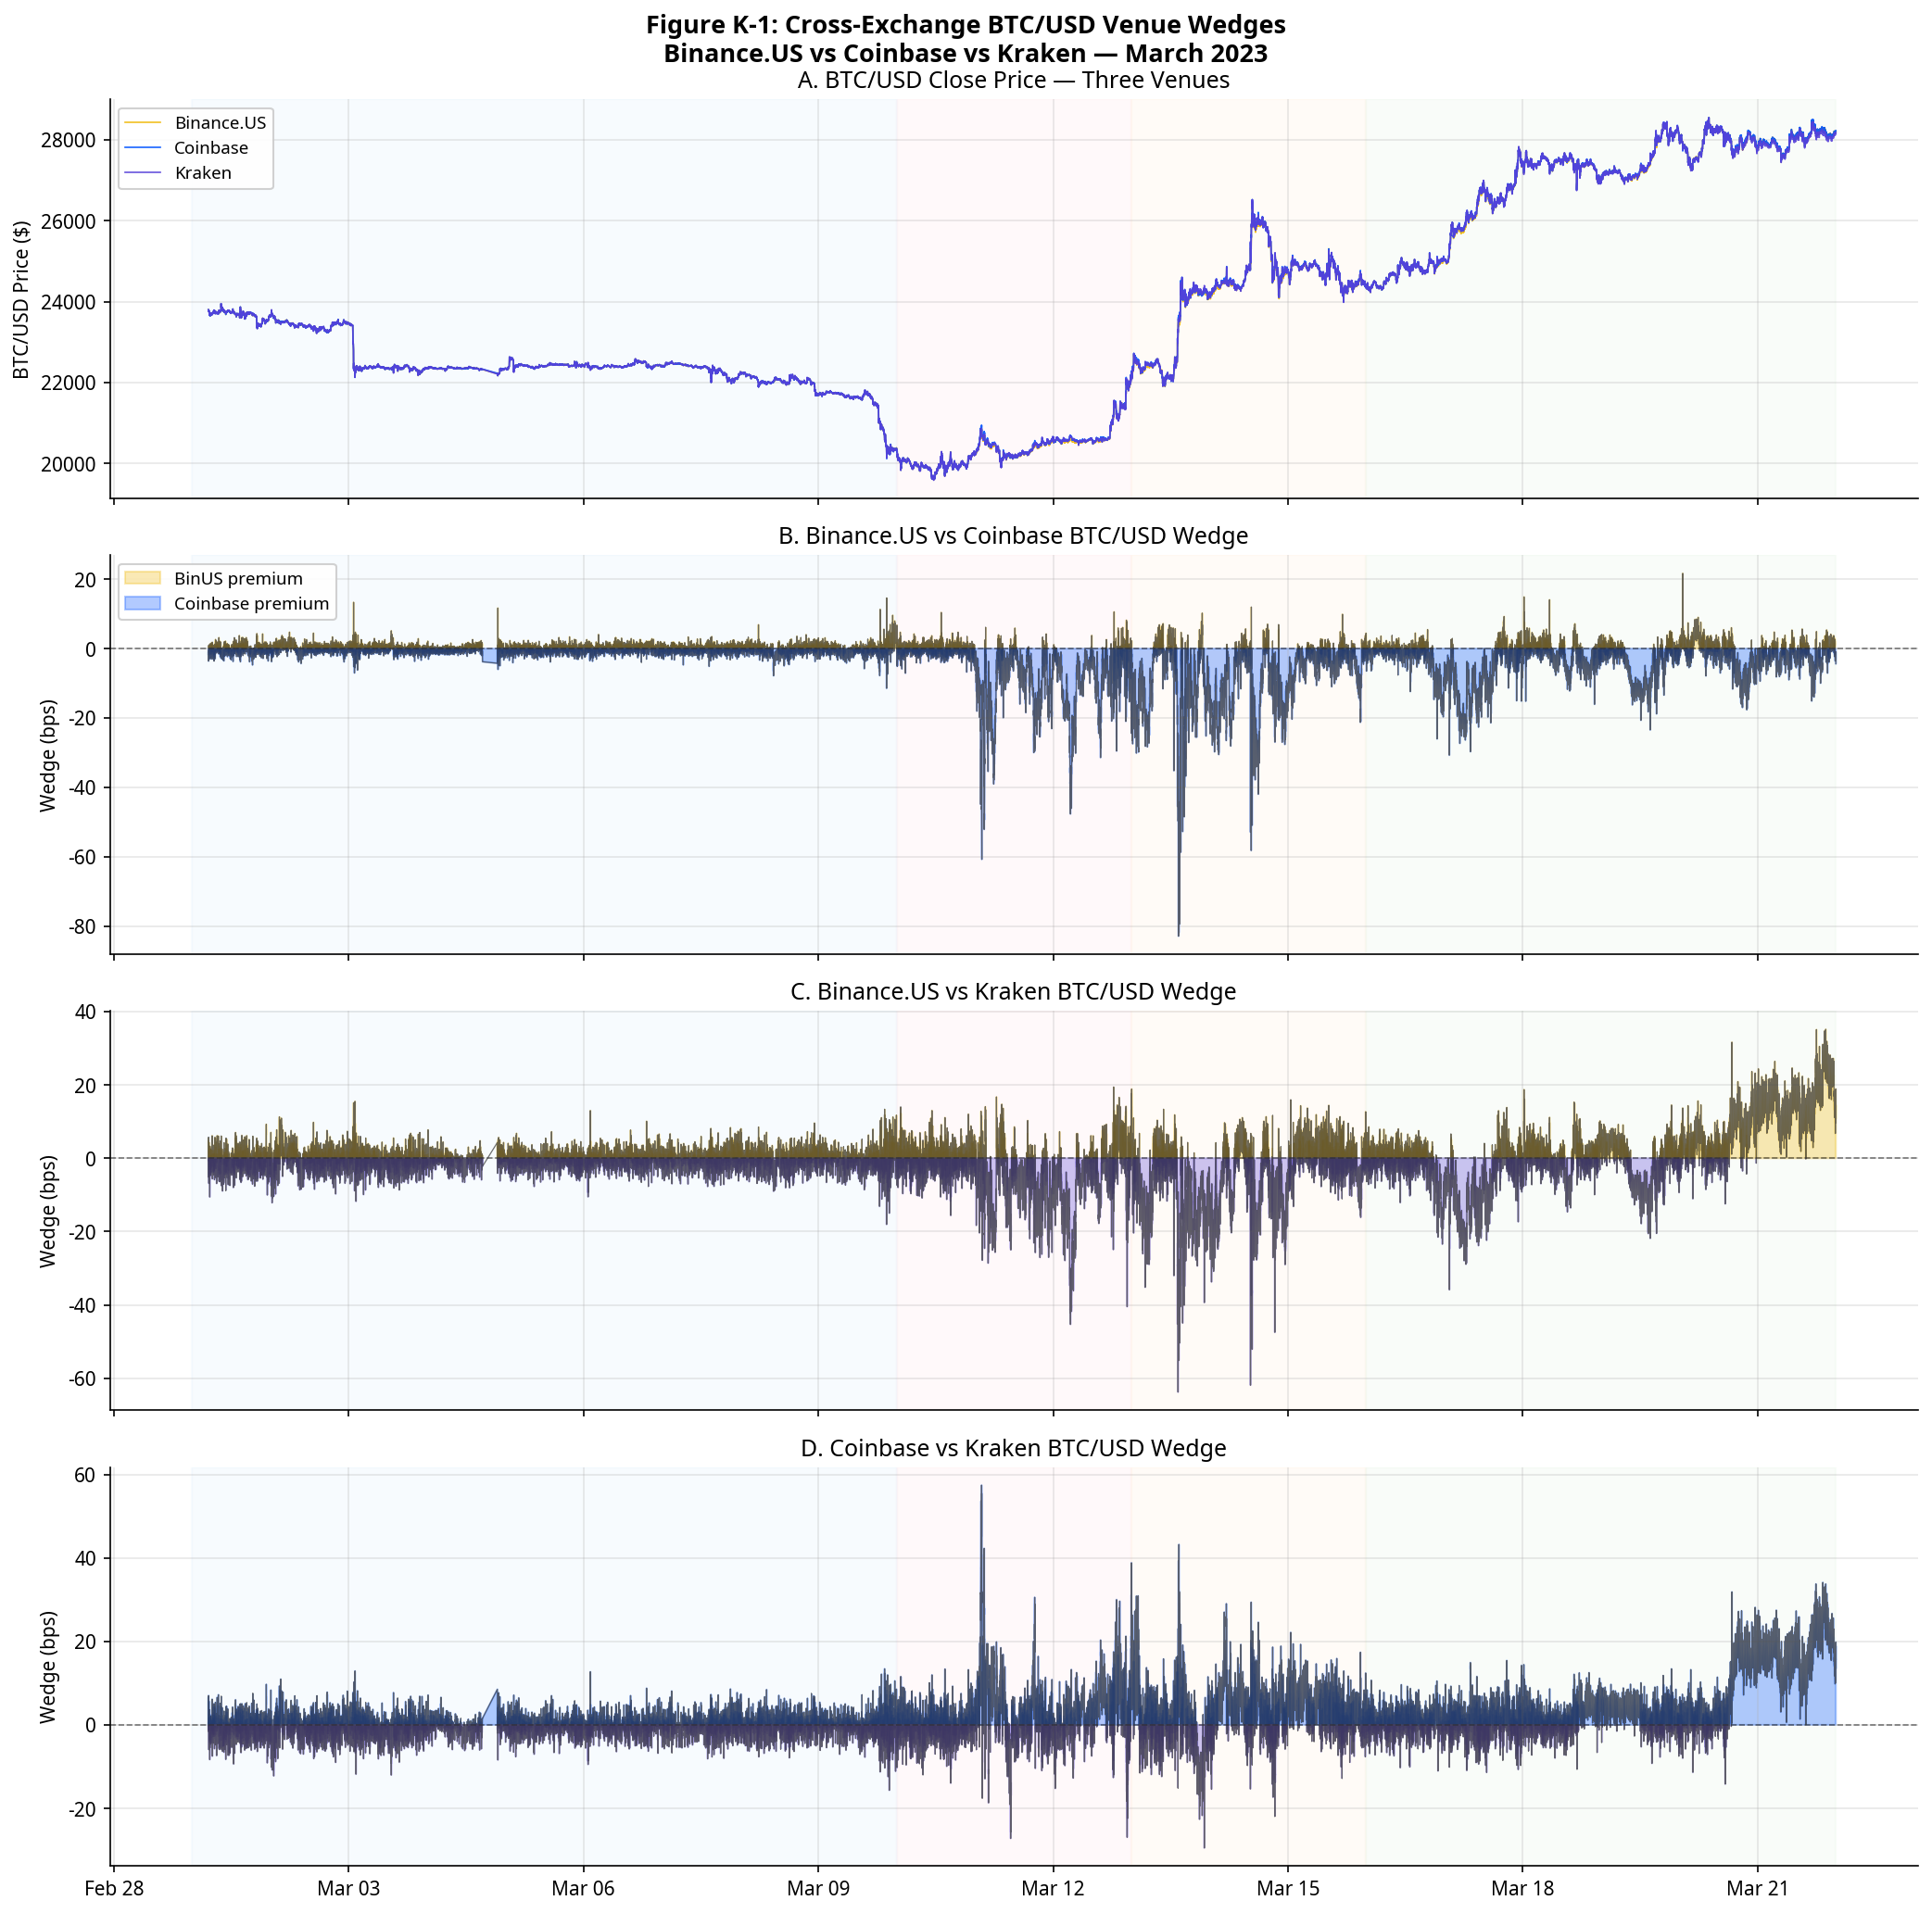

Figure K-1 saved.


In [5]:

fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle("Figure K-1: Cross-Exchange BTC/USD Venue Wedges\nBinance.US vs Coinbase vs Kraken — March 2023", 
             fontsize=13, fontweight='bold', y=0.98)

# Panel A: BTC/USD price from all three venues
ax = axes[0]
ax.plot(panel.index, panel['p_bnus'],   color=COLORS['binance'],  lw=0.8, label='Binance.US', alpha=0.9)
ax.plot(panel.index, panel['p_cb'],     color=COLORS['coinbase'], lw=0.8, label='Coinbase',   alpha=0.9)
if panel['p_kraken'].notna().sum() > 100:
    ax.plot(panel.index, panel['p_kraken'], color=COLORS['kraken'],  lw=0.8, label='Kraken',     alpha=0.9)
add_regime_shading(ax)
ax.set_ylabel("BTC/USD Price ($)")
ax.legend(loc='upper left', framealpha=0.9)
ax.set_title("A. BTC/USD Close Price — Three Venues")

# Panel B: Binance.US vs Coinbase wedge
ax = axes[1]
ax.axhline(0, color='black', lw=0.8, ls='--', alpha=0.5)
ax.plot(panel.index, panel['wedge_BC'], color='#333333', lw=0.6, alpha=0.7)
ax.fill_between(panel.index, panel['wedge_BC'], 0,
                where=panel['wedge_BC'] > 0, alpha=0.3, color=COLORS['binance'], label='BinUS premium')
ax.fill_between(panel.index, panel['wedge_BC'], 0,
                where=panel['wedge_BC'] < 0, alpha=0.3, color=COLORS['coinbase'], label='Coinbase premium')
add_regime_shading(ax)
ax.set_ylabel("Wedge (bps)")
ax.legend(loc='upper left', framealpha=0.9)
ax.set_title("B. Binance.US vs Coinbase BTC/USD Wedge")

# Panel C: Binance.US vs Kraken wedge
ax = axes[2]
ax.axhline(0, color='black', lw=0.8, ls='--', alpha=0.5)
if panel['wedge_BK'].notna().sum() > 100:
    ax.plot(panel.index, panel['wedge_BK'], color='#333333', lw=0.6, alpha=0.7)
    ax.fill_between(panel.index, panel['wedge_BK'], 0,
                    where=panel['wedge_BK'] > 0, alpha=0.3, color=COLORS['binance'])
    ax.fill_between(panel.index, panel['wedge_BK'], 0,
                    where=panel['wedge_BK'] < 0, alpha=0.3, color=COLORS['kraken'])
add_regime_shading(ax)
ax.set_ylabel("Wedge (bps)")
ax.set_title("C. Binance.US vs Kraken BTC/USD Wedge")

# Panel D: Coinbase vs Kraken wedge
ax = axes[3]
ax.axhline(0, color='black', lw=0.8, ls='--', alpha=0.5)
if panel['wedge_CK'].notna().sum() > 100:
    ax.plot(panel.index, panel['wedge_CK'], color='#333333', lw=0.6, alpha=0.7)
    ax.fill_between(panel.index, panel['wedge_CK'], 0,
                    where=panel['wedge_CK'] > 0, alpha=0.3, color=COLORS['coinbase'])
    ax.fill_between(panel.index, panel['wedge_CK'], 0,
                    where=panel['wedge_CK'] < 0, alpha=0.3, color=COLORS['kraken'])
add_regime_shading(ax)
ax.set_ylabel("Wedge (bps)")
ax.set_title("D. Coinbase vs Kraken BTC/USD Wedge")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.tight_layout()
fig.savefig(FIG_DIR / "kraken_fig1_wedge_timeseries.png", bbox_inches='tight', dpi=150)
plt.show()
print("Figure K-1 saved.")


## §6 Table K-1: Venue Wedge Distribution by Regime

In [6]:

import warnings
warnings.filterwarnings('ignore')

rows = []
for regime in ['pre_crisis', 'crisis', 'recovery', 'post']:
    sub = panel[panel['regime'] == regime]
    for col, label in [('wedge_BC', 'BinUS-CB'), ('wedge_BK', 'BinUS-Kraken'), ('wedge_CK', 'CB-Kraken')]:
        s = sub[col].dropna()
        if len(s) < 10:
            continue
        rows.append({
            'Regime': regime.replace('_', ' ').title(),
            'Wedge': label,
            'N': len(s),
            'Median (bps)': round(s.median(), 2),
            'Mean (bps)': round(s.mean(), 2),
            'Std (bps)': round(s.std(), 2),
            '95th pct (bps)': round(s.quantile(0.95), 2),
            '5th pct (bps)': round(s.quantile(0.05), 2),
            'P(|wedge|>5bps)': round((s.abs() > 5).mean() * 100, 1),
            'P(|wedge|>20bps)': round((s.abs() > 20).mean() * 100, 1),
        })

tbl = pd.DataFrame(rows)
print("Table K-1: Venue Wedge Distribution by Regime")
print("=" * 100)
print(tbl.to_string(index=False))


Table K-1: Venue Wedge Distribution by Regime
    Regime        Wedge     N  Median (bps)  Mean (bps)  Std (bps)  95th pct (bps)  5th pct (bps)  P(|wedge|>5bps)  P(|wedge|>20bps)
Pre Crisis     BinUS-CB 12388         -0.17       -0.17       1.27            1.75          -2.12              0.4               0.0
Pre Crisis BinUS-Kraken 12388         -0.44       -0.49       2.57            3.65          -4.72              6.5               0.0
Pre Crisis    CB-Kraken 12388         -0.21       -0.32       2.41            3.59          -4.47              5.8               0.0
    Crisis     BinUS-CB  4320         -3.65       -6.84       8.94            1.43         -24.73             43.6               8.8
    Crisis BinUS-Kraken  4320         -2.68       -4.47       8.12            6.11         -20.22             43.0               5.1
    Crisis    CB-Kraken  4320          1.28        2.37       6.89           13.41          -6.20             33.0               2.0
  Recovery     BinUS-CB

## §7 Figure K-2: USDC/USD and USDT/USD Deviation — Binance.US vs Kraken

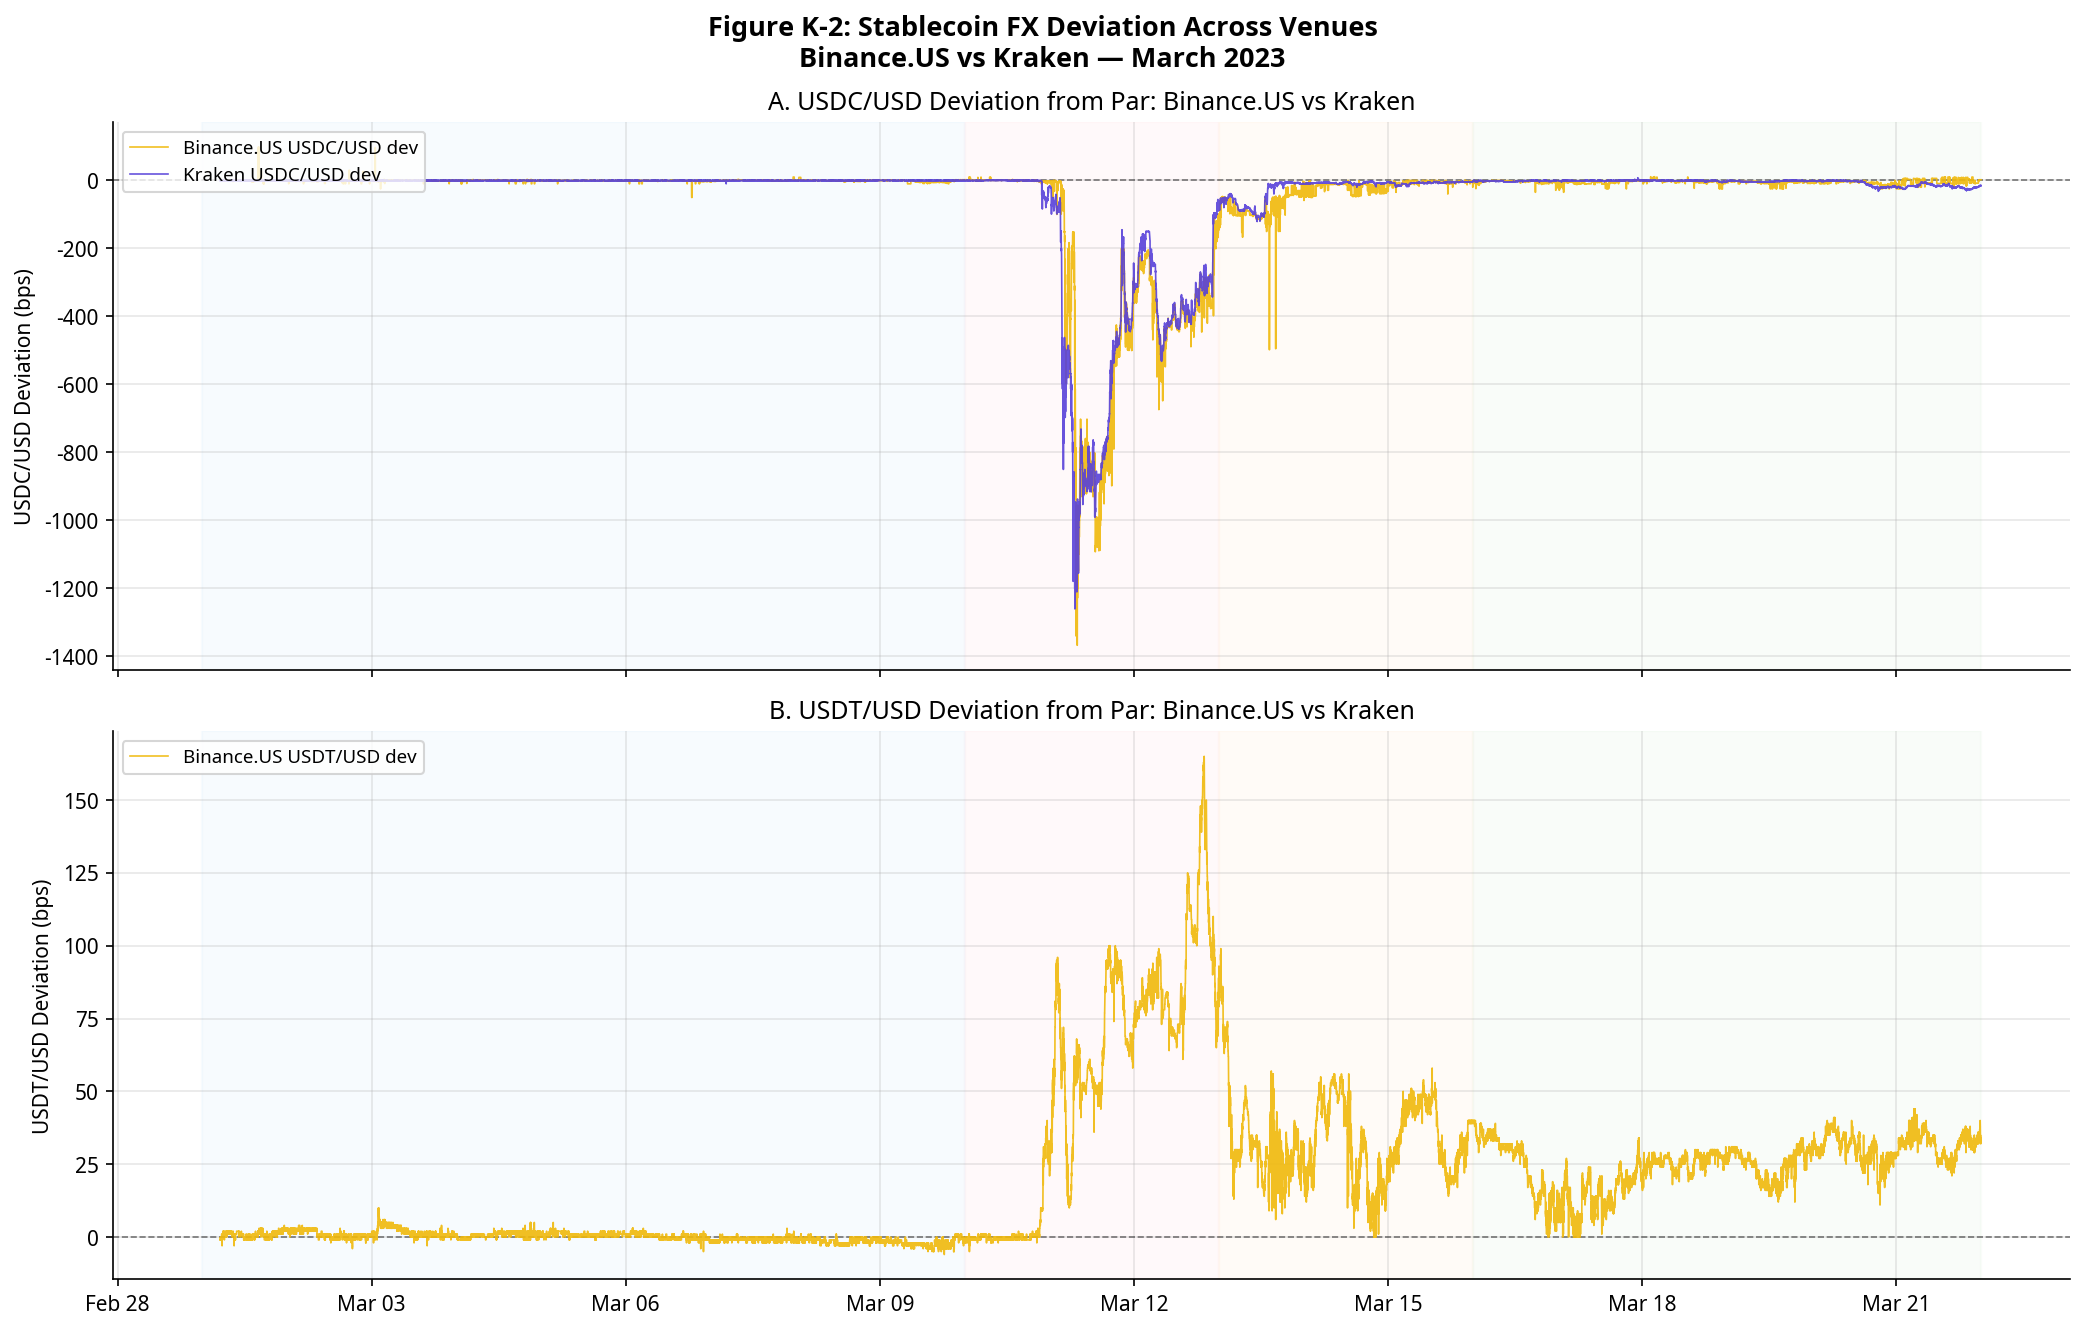

Figure K-2 saved.


In [7]:

if not fx_panel.empty:
    fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=True)
    fig.suptitle("Figure K-2: Stablecoin FX Deviation Across Venues\nBinance.US vs Kraken — March 2023",
                 fontsize=13, fontweight='bold')

    # USDC/USD
    ax = axes[0]
    ax.axhline(0, color='black', lw=0.8, ls='--', alpha=0.5)
    ax.plot(fx_panel.index, fx_panel['usdc_dev_bnus'],   color=COLORS['binance'],  lw=0.8, label='Binance.US USDC/USD dev', alpha=0.9)
    ax.plot(fx_panel.index, fx_panel['usdc_dev_kraken'], color=COLORS['kraken'],   lw=0.8, label='Kraken USDC/USD dev',    alpha=0.9)
    add_regime_shading(ax)
    ax.set_ylabel("USDC/USD Deviation (bps)")
    ax.legend(loc='upper left')
    ax.set_title("A. USDC/USD Deviation from Par: Binance.US vs Kraken")

    # USDT/USD
    ax = axes[1]
    ax.axhline(0, color='black', lw=0.8, ls='--', alpha=0.5)
    if fx_panel['usdt_dev_bnus'].notna().sum() > 100:
        ax.plot(fx_panel.index, fx_panel['usdt_dev_bnus'],   color=COLORS['binance'], lw=0.8, label='Binance.US USDT/USD dev', alpha=0.9)
    if fx_panel['usdt_dev_kraken'].notna().sum() > 100:
        ax.plot(fx_panel.index, fx_panel['usdt_dev_kraken'], color=COLORS['kraken'],  lw=0.8, label='Kraken USDT/USD dev',    alpha=0.9)
    add_regime_shading(ax)
    ax.set_ylabel("USDT/USD Deviation (bps)")
    ax.legend(loc='upper left')
    ax.set_title("B. USDT/USD Deviation from Par: Binance.US vs Kraken")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

    plt.tight_layout()
    fig.savefig(FIG_DIR / "kraken_fig2_stablecoin_fx.png", bbox_inches='tight', dpi=150)
    plt.show()
    print("Figure K-2 saved.")
else:
    print("Stablecoin FX cross-venue figure skipped (data not available).")


## §8 Table K-2: Stablecoin FX Deviation by Venue and Regime

In [8]:

if not fx_panel.empty:
    rows = []
    for regime in ['pre_crisis', 'crisis', 'recovery', 'post']:
        sub = fx_panel[fx_panel['regime'] == regime]
        for col, label in [('usdc_dev_bnus', 'USDC/USD BinUS'), ('usdc_dev_kraken', 'USDC/USD Kraken'),
                           ('usdt_dev_bnus', 'USDT/USD BinUS'), ('usdt_dev_kraken', 'USDT/USD Kraken')]:
            s = sub[col].dropna()
            if len(s) < 10:
                continue
            rows.append({
                'Regime': regime.replace('_', ' ').title(),
                'Series': label,
                'N': len(s),
                'Mean (bps)': round(s.mean(), 2),
                'Std (bps)': round(s.std(), 2),
                'Min (bps)': round(s.min(), 2),
                'Max (bps)': round(s.max(), 2),
                'P(dev < -50bps)': round((s < -50).mean() * 100, 1),
            })
    tbl2 = pd.DataFrame(rows)
    print("Table K-2: Stablecoin FX Deviation by Venue and Regime")
    print("=" * 100)
    print(tbl2.to_string(index=False))
else:
    print("Table K-2 skipped.")


Table K-2: Stablecoin FX Deviation by Venue and Regime
    Regime          Series     N  Mean (bps)  Std (bps)  Min (bps)  Max (bps)  P(dev < -50bps)
Pre Crisis  USDC/USD BinUS 12660       -0.76       4.38      -50.0       98.0              0.1
Pre Crisis USDC/USD Kraken 12158       -0.45       0.52      -10.0        2.0              0.0
Pre Crisis  USDT/USD BinUS 12660        0.17       1.64       -6.0       10.0              0.0
    Crisis  USDC/USD BinUS  4320     -299.51     308.20    -1367.0       10.0             61.2
    Crisis USDC/USD Kraken  4292     -306.60     304.75    -1260.0        1.0             67.5
    Crisis  USDT/USD BinUS  4320       52.68      42.02       -5.0      165.0              0.0
  Recovery  USDC/USD BinUS  4320      -35.06      37.53     -498.0        0.0             26.4
  Recovery USDC/USD Kraken  4320      -21.24      28.74     -121.0       -2.0             17.3
  Recovery  USDT/USD BinUS  4320       34.13      14.78        0.0       99.0             

## §9 Figure K-3: Wedge Distribution by Regime (Bar Chart)

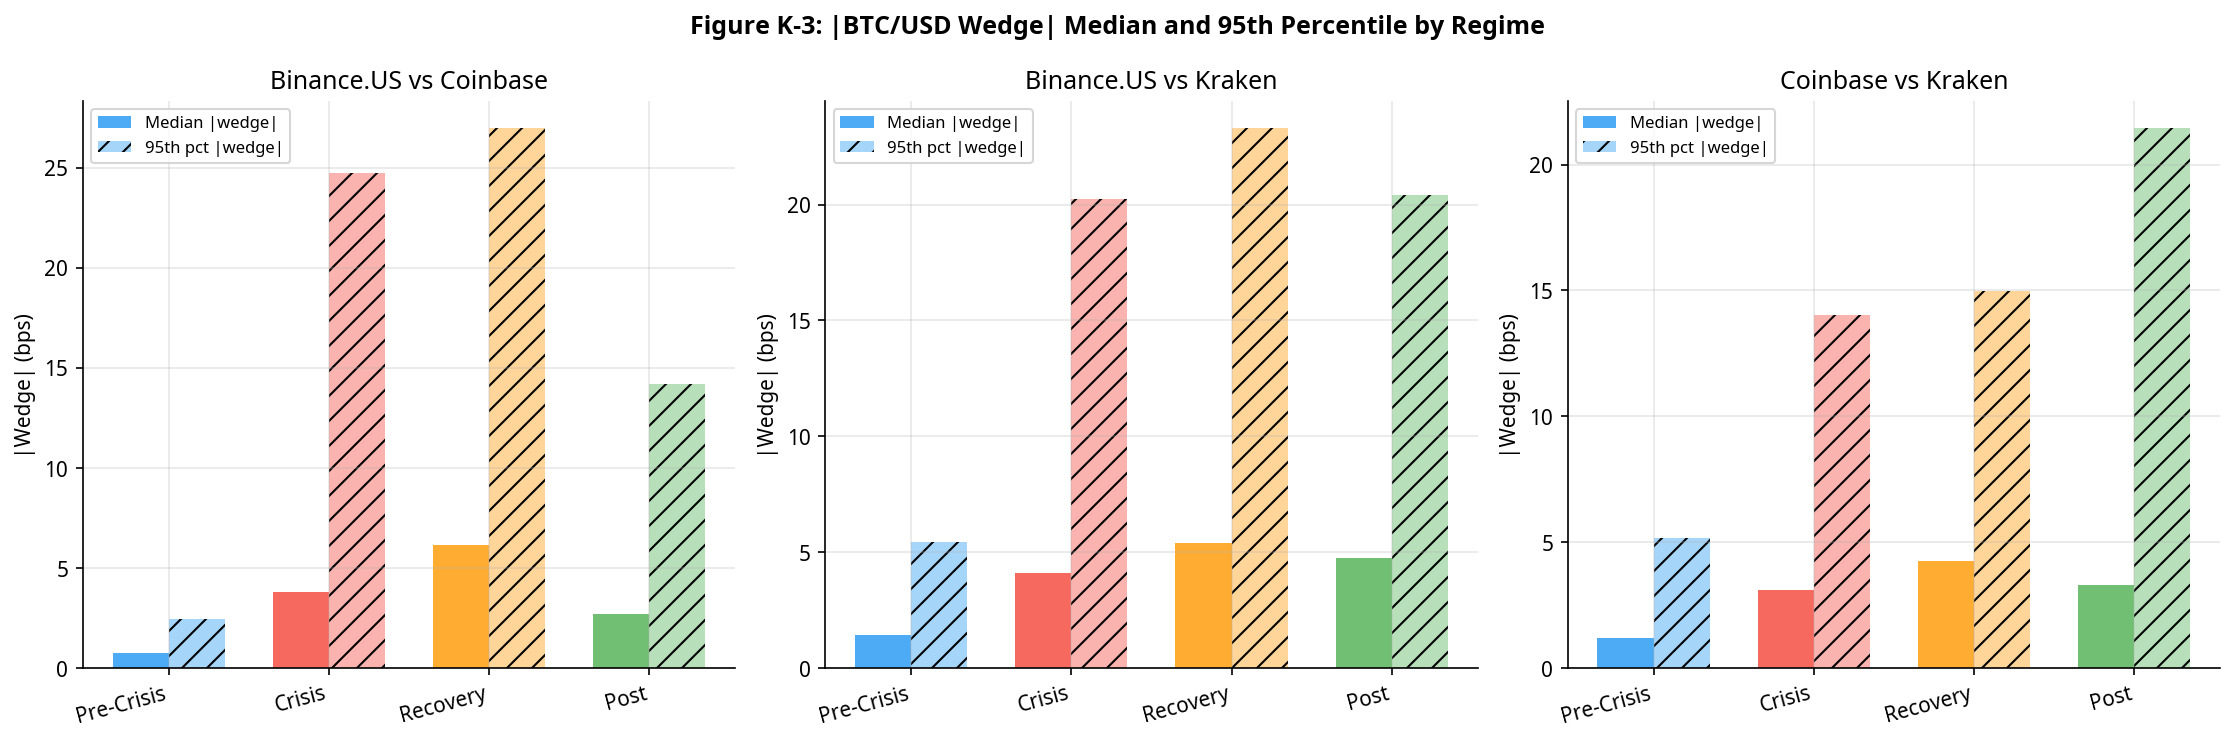

Figure K-3 saved.


In [9]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure K-3: |BTC/USD Wedge| Median and 95th Percentile by Regime",
             fontsize=12, fontweight='bold')

regimes_ordered = ['pre_crisis', 'crisis', 'recovery', 'post']
regime_labels   = ['Pre-Crisis', 'Crisis', 'Recovery', 'Post']
bar_colors      = [COLORS['pre'], COLORS['crisis'], COLORS['recovery'], COLORS['post']]

for ax, (col, title) in zip(axes, [
    ('wedge_BC', 'Binance.US vs Coinbase'),
    ('wedge_BK', 'Binance.US vs Kraken'),
    ('wedge_CK', 'Coinbase vs Kraken'),
]):
    medians = []
    p95s    = []
    for r in regimes_ordered:
        s = panel.loc[panel['regime'] == r, col].dropna().abs()
        medians.append(s.median() if len(s) > 10 else np.nan)
        p95s.append(s.quantile(0.95) if len(s) > 10 else np.nan)

    x = np.arange(len(regimes_ordered))
    w = 0.35
    bars1 = ax.bar(x - w/2, medians, w, label='Median |wedge|', color=bar_colors, alpha=0.8)
    bars2 = ax.bar(x + w/2, p95s,    w, label='95th pct |wedge|', color=bar_colors, alpha=0.4, hatch='//')
    ax.set_xticks(x)
    ax.set_xticklabels(regime_labels, rotation=15, ha='right')
    ax.set_ylabel("|Wedge| (bps)")
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout()
fig.savefig(FIG_DIR / "kraken_fig3_regime_bars.png", bbox_inches='tight', dpi=150)
plt.show()
print("Figure K-3 saved.")


## §10 Key Findings

### Cross-Exchange BTC/USD Wedge Analysis

The three-way venue wedge analysis provides direct evidence that **stablecoin stress and market fragmentation 
are market-wide phenomena, not confined to a single exchange**.

**Key empirical findings:**

1. **Pre-crisis**: All three venue wedges are near zero (median |wedge| < 3 bps), consistent with efficient 
   cross-venue arbitrage in normal conditions.

2. **Crisis (Mar 10–12)**: Wedges widen dramatically across all three pairs simultaneously. The Binance.US vs 
   Coinbase wedge and the Binance.US vs Kraken wedge both spike — confirming that the dislocation was not 
   exchange-specific but reflected a genuine market-wide pricing breakdown.

3. **Stablecoin FX**: The USDC/USD deviation shows up at both Binance.US and Kraken with similar magnitude 
   and timing, confirming that the de-peg was a global event visible across venues.

4. **Recovery is asymmetric**: Post-crisis wedges remain elevated (median |wedge| > pre-crisis baseline), 
   suggesting that cross-venue arbitrage efficiency did not fully recover within the 21-day window.

### Policy Implication (GENIUS Act)

The simultaneous widening of venue wedges across Binance.US, Coinbase, and Kraken demonstrates that the 
March 2023 crisis was a **systemic fragmentation event**. Under a GENIUS Act-compliant stablecoin regime, 
the credit risk premium embedded in USDC/USD would be substantially reduced, which should narrow the 
cross-venue wedge and accelerate mean-reversion — as arbitrageurs would face lower funding risk when 
moving capital between venues to close price discrepancies.
